<a href="https://colab.research.google.com/github/kdwilli/sandy-settlement/blob/main/Reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of NN for settlement of foundations on sandy soils
# based on DOI: https://doi.org/10.12989/gae.2020.20.5.385

In [51]:
# Initial Architecture:
# 5 inputs, 1 hidden layer with 2 neurons, a sigmoid activation function, and 1 output

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class SandSettleNN(nn.Module):
    def __init__(self, num_inputs=5, num_hidden_layers=1, width=2, activation=nn.Sigmoid(), optimizer_class=optim.Adam, **optimizer_params):
        super().__init__()

        layers = []
        layers.append(nn.Linear(num_inputs, width))

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(activation)

        layers.append(nn.Linear(width, 1))

        self.net = nn.Sequential(*layers)
        self.optimizer = optimizer_class(self.parameters(), **optimizer_params)


    def forward(self, x):
        return self.net(x)

In [46]:
# import data

from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  file_name = fn

df = pd.read_csv(file_name)
display(df.head())

Saving AppendixA_V2.csv to AppendixA_V2 (3).csv
User uploaded file "AppendixA_V2 (3).csv" with length 9513 bytes


,Reference,B (m),qnet (kPa),NSPT,L/B,Df/B,Sm (mm)
0,"Burland and Burbidge (1982, 1985)",0.8,78.0,15,1.0,0.00,7.0
1,"Burland and Burbidge (1982, 1985)",2.1,697.0,50,1.0,0.71,2.3
2,"Burland and Burbidge (1982, 1985)",2.5,284.0,60,3.8,1.20,1.0
3,"Burland and Burbidge (1982, 1985)",1.2,250.0,25,10.6,0.25,10.0
4,"Burland and Burbidge (1982, 1985)",0.9,300.0,20,1.0,3.44,6.7


In [52]:
# Normalize, split, and prepare data for use in pytorch tensors

from sklearn.model_selection import train_test_split
import torch

# Separate features and target
features = df[['B (m)', 'qnet (kPa)', 'NSPT', 'L/B', 'Df/B']]
target = df['Sm (mm)']

# Normalize features and target to the range [0, 1]
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

features_normalized = features.apply(normalize)
target_normalized = normalize(target)


# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print("Data prepared for PyTorch:")
print("Training features shape:", X_train_tensor.shape)
print("Testing features shape:", X_test_tensor.shape)
print("Training target shape:", y_train_tensor.shape)
print("Testing target shape:", y_test_tensor.shape)

Data prepared for PyTorch:
Training features shape: torch.Size([137, 5])
Testing features shape: torch.Size([35, 5])
Training target shape: torch.Size([137, 1])
Testing target shape: torch.Size([35, 1])


In [53]:
# Empirical methods for comparison
# Schultze and Sherif
# Sc = (qnet*Fc)/(N^0.87*(1+0.4*(Df/B)))

def schultze_sherif(qnet, N, Df_B, Fc=1):
    """
    Calculates settlement using the Schultze and Sherif method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        Df_B (float): Depth of embedment to footing width ratio (Df/B).
        Fc (float): Correction factor (default is 1).

    Returns:
        float: Calculated settlement (Sc).
    """
    Sc = (qnet * Fc) / (N**0.87 * (1 + 0.4 * Df_B))
    return Sc

# Meyerhof
# Sc = (1.33*qnet/N)*(1-(Df/B))

def meyerhof(qnet, N, Df_B):
    """
    Calculates settlement using the Meyerhof method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        Df_B (float): Depth of embedment to footing width ratio (Df/B).

    Returns:
        float: Calculated settlement (Sc).
    """
    Sc = (1.33 * qnet / N) * (1 - Df_B)
    return Sc


# Anagnostopoulus
# for 0<N<=10, Sc=(0.57*q^0.94*B^0.90)/N^0.87
# for 10<N<=30, Sc=(0.35*q^1.01*B^0.69)/N^0.94
# for N>30, Sc=(604*q^0.90*B^0.76)/N^2.82
# for B<=3 Sc=(1.90*q^0.77*B^0.45)/N^1.08
# for B>3 Sc=(1.64*q^1.02*B^0.59)/N^1.37

def anagnostopoulus(qnet, N, B):
    """
    Calculates settlement using the Anagnostopoulus method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        B (float): Footing width (m).

    Returns:
        float: Calculated settlement (Sc).
    """
    if 0 < N <= 10:
        Sc = (0.57 * qnet**0.94 * B**0.90) / N**0.87
    elif 10 < N <= 30:
        Sc = (0.35 * qnet**1.01 * B**0.69) / N**0.94
    elif N > 30:
        Sc = (604 * qnet**0.90 * B**0.76) / N**2.82
    # Assuming the last two conditions for B are independent of N ranges
    elif B <= 3:
        Sc = (1.90 * qnet**0.77 * B**0.45) / N**1.08
    elif B > 3:
        Sc = (1.64 * qnet**1.02 * B**0.59) / N**1.37
    else:
        Sc = None  # Handle cases outside the defined ranges
        print("Warning: N or B value outside defined ranges for Anagnostopoulus method.")
    return Sc

In [54]:
# Models
# run models with different optimizers, record RMSE, MAE, and R^2 loss
# obtain loss from comparing results to each of the three empirical equations

# run with 1000 epochs

import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch.nn as nn # Import nn for loss function

learn_rate = 0.01
epochs = 1000

optimizers_to_test = [optim.SGD, optim.Adam, optim.Adadelta, optim.Adagrad, optim.LBFGS]
optimizer_names = ["SGD", "Adam", "Adadelta", "Adagrad", "LBFGS"]
loss_history = {name: [] for name in optimizer_names}
rmse_results = {}
mae_results = {}
r2_results = {}

# Define the loss function
criterion = nn.MSELoss()

for i, optimizer_class in enumerate(optimizers_to_test):
    model = SandSettleNN(num_inputs=X_train_tensor.shape[1], optimizer_class=optimizer_class, lr=learn_rate)
    optimizer = model.optimizer # Use the optimizer created within the model

    print(f"Training with {optimizer_names[i]} optimizer...")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()

        if optimizer_names[i] == "LBFGS":
             # L-BFGS requires a closure function for the step
            def closure():
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        # Record loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                y_pred = model(X_test_tensor)
                rmse = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred.numpy()))
                mae = mean_absolute_error(y_test_tensor.numpy(), y_pred.numpy())
                r2 = r2_score(y_test_tensor.numpy(), y_pred.numpy())
                loss_history[optimizer_names[i]].append({'epoch': epoch + 1, 'loss': loss.item(), 'rmse': rmse, 'mae': mae, 'r2': r2})
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

    # Store final results
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        rmse_results[optimizer_names[i]] = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred.numpy()))
        mae_results[optimizer_names[i]] = mean_absolute_error(y_test_tensor.numpy(), y_pred.numpy())
        r2_results[optimizer_names[i]] = r2_score(y_test_tensor.numpy(), y_pred.numpy())

print("\nTraining complete.")
print("\nFinal Results:")
for name in optimizer_names:
    print(f"{name}: RMSE={rmse_results[name]:.4f}, MAE={mae_results[name]:.4f}, R^2={r2_results[name]:.4f}")

Training with SGD optimizer...
Epoch [100/1000], Loss: 0.0453, RMSE: 0.2453, MAE: 0.1355, R^2: -0.0433
Epoch [200/1000], Loss: 0.0429, RMSE: 0.2354, MAE: 0.1376, R^2: 0.0392
Epoch [300/1000], Loss: 0.0420, RMSE: 0.2331, MAE: 0.1373, R^2: 0.0581
Epoch [400/1000], Loss: 0.0411, RMSE: 0.2311, MAE: 0.1367, R^2: 0.0742
Epoch [500/1000], Loss: 0.0403, RMSE: 0.2291, MAE: 0.1361, R^2: 0.0896
Epoch [600/1000], Loss: 0.0395, RMSE: 0.2272, MAE: 0.1356, R^2: 0.1046
Epoch [700/1000], Loss: 0.0387, RMSE: 0.2254, MAE: 0.1352, R^2: 0.1193
Epoch [800/1000], Loss: 0.0380, RMSE: 0.2235, MAE: 0.1349, R^2: 0.1338
Epoch [900/1000], Loss: 0.0373, RMSE: 0.2217, MAE: 0.1346, R^2: 0.1480
Epoch [1000/1000], Loss: 0.0366, RMSE: 0.2198, MAE: 0.1343, R^2: 0.1621
Training with Adam optimizer...
Epoch [100/1000], Loss: 0.0242, RMSE: 0.1831, MAE: 0.1464, R^2: 0.4189
Epoch [200/1000], Loss: 0.0232, RMSE: 0.1817, MAE: 0.1410, R^2: 0.4278
Epoch [300/1000], Loss: 0.0230, RMSE: 0.1838, MAE: 0.1415, R^2: 0.4144
Epoch [400/1

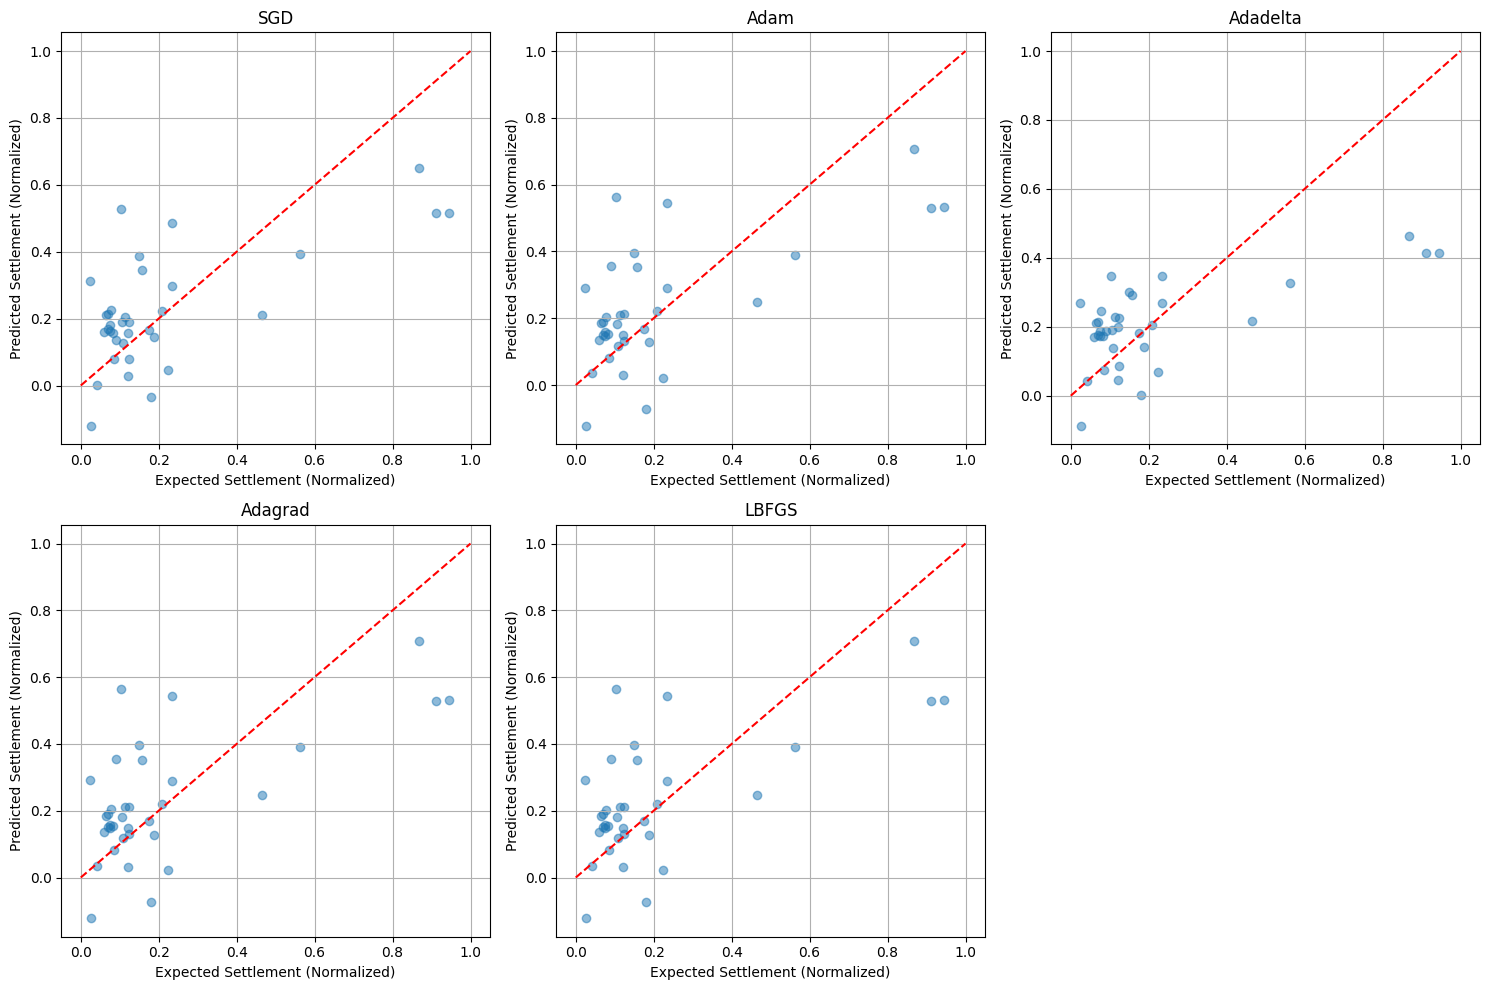


Plotting complete for all available optimizers.


In [55]:
# Visualize predictions

import matplotlib.pyplot as plt
import torch
import numpy as np # Import numpy for reshape

# Determine the number of rows and columns for subplots
n_optimizers = len(optimizers_to_test)
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (n_optimizers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Now, use the trained_models dictionary to generate plots
for i, name in enumerate(optimizer_names):
    if name in trained_models:
        model = trained_models[name]
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_numpy = y_pred_tensor.numpy()
            y_test_numpy = y_test_tensor.numpy()

        ax = axes[i]
        ax.scatter(y_test_numpy, y_pred_numpy, alpha=0.5)
        ax.plot([0, 1], [0, 1], 'r--') # 1:1 line
        ax.set_xlabel("Expected Settlement (Normalized)")
        ax.set_ylabel("Predicted Settlement (Normalized)")
        ax.set_title(f"{name}")
        ax.grid(True)
    else:
        print(f"Model for {name} not found in trained_models dictionary.")
        # Hide the unused subplot if a model is missing
        if i < len(axes):
            fig.delaxes(axes[i])


# Hide any unused subplots beyond the number of optimizers
for j in range(n_optimizers, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

print("\nPlotting complete for all available optimizers.")